In [1]:
# installation of required libraries
!pip install torch torchvision torchaudio

In [2]:
# installation of required libraries
!pip install graphviz

In [3]:
# installation of required libraries
!pip install torch-geometric

In [4]:
# IMPORT SECTION
import numpy as np
import zipfile
import pandas as pd
import ipaddress
from ipaddress import ip_network
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.manifold import TSNE
from graphviz import Source

In [5]:
import os
import random
import numpy as np
import torch

# Set the seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Environment-level reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'  # For CUDA determinism (if supported)

# PyTorch deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
# path to the version 1.0 of the provided data
version10 = "output_ml_students.zip"
# path to the version 1.1 of the provided data
version11 = "output_ml_students_twosets.zip"

def my_read_fn(label):
    mapping = {
        "backend_prop": (version10, "backend_assetproperty.csv"),
        "backend_relservicemetric": (version10, "backend_assetrelationshipservicemetric.csv"),
        "backend_relservices": (version10,"backend_assetrelationshipservice.csv"),
        "backend_relations": (version10,"backend_assetrelationship.csv"),
        "backend_types": (version10,"backend_assettype.csv"),
        "backend_asset": (version10,"backend_asset.csv"),
        "swiss_prop": (version11, "swisstools_asset_properties.csv"),
        "swiss_relservice_metrics": (version11, "swisstools_asset_relationship_service_metrics.csv"),
        "swiss_relservices": (version11, "swisstools_asset_relationship_services.csv"),
        "swiss_relations": (version11, "swisstools_asset_relationships.csv"),
        "swiss_types": (version11, "swisstools_asset_types.csv"),
        "swiss_asset": (version11, "swisstools_assets.csv"),
    }

    arch, filename = mapping[label]

    with zipfile.ZipFile(arch, 'r') as z:
        file_list = z.namelist()
        def find_file(target):
            return next((f for f in file_list if f.endswith(target)), None)

        file_in_zip = find_file(filename)
        if not file_in_zip:
            raise FileNotFoundError(f"{filename} not found in {arch}")

        return pd.read_csv(z.open(file_in_zip), low_memory=False)

backend_prop = my_read_fn("backend_prop")
backend_relservicemetric = my_read_fn("backend_relservicemetric")
backend_relservices = my_read_fn("backend_relservices")
backend_relations = my_read_fn("backend_relations")
backend_types = my_read_fn("backend_types")
backend_asset = my_read_fn("backend_asset")
swiss_prop = my_read_fn("swiss_prop")
swiss_relservice_metrics = my_read_fn("swiss_relservice_metrics")
swiss_relservices = my_read_fn("swiss_relservices")
swiss_relations = my_read_fn("swiss_relations")
swiss_types = my_read_fn("swiss_types")
swiss_asset = my_read_fn("swiss_asset")

In [7]:
def network_to_int(ip):
        """
        Convert IP address string to an integer.

        Parameters:
            ip (str): The IP address in string format (e.g., '192.168.1.0/24').

        Returns:
            int or None: The integer representation of the network address, or None if conversion fails.
        """
        try:
            return int(ip_network(ip, strict=False).network_address)
        except:
            return None

def mac_to_int(mac):
        """
        Convert MAC address to an integer by removing delimiters.

        Parameters:
            mac (str): The MAC address in string format (e.g., '00:1A:2B:3C:4D:5E' or '00-1A-2B-3C-4D-5E').

        Returns:
            int or None: The integer representation of the MAC address, or None if conversion fails.

        """
        try:
            return int(mac.replace(":", "").replace("-", "").lower(), 16)
        except:
            return None
def extract_first_vlan(vlan_str):
        """
        Extract the first VLAN ID from a string of comma-separated VLANs.

        Parameters:
            vlan_str (str): A string representing VLAN IDs (e.g., {2011}, or '{100,200,300}').

        Returns:
            int or None: The first VLAN ID as an integer, 0 if input is empty, or None if extraction fails.
        """

        try:
            if pd.isna(vlan_str) or vlan_str.strip('{}').strip() == '':
                return 0
            return int(vlan_str.strip('{}').split(',')[0].strip())
        except:
            return None
label_encoder = LabelEncoder()
# Drop unnecessary columns from Swiss asset data
swiss_asset=swiss_asset.drop(columns=['name','hostname','active','location_id','assigned_value','estimated_value'])
# Remove rows with missing asset_type_id (critical for joins)
swiss_asset = swiss_asset.dropna(subset=['asset_type_id'])
# Map 'processing_state' to a binary flag
swiss_asset['processing_state'] = swiss_asset['processing_state'].map({
    'QUEUED': 1,
    'PROCESSED': 0
})
# Convert IP/MAC/VLAN features to integers
swiss_asset['ipaddress'] = swiss_asset['ipaddress'].apply(network_to_int)
swiss_asset['mac_address'] = swiss_asset['mac_address'].apply(mac_to_int)
swiss_asset['vlan_ids'] = swiss_asset['vlan_ids'].apply(extract_first_vlan)
# Calculate device age
swiss_asset['date_created'] = pd.to_datetime(swiss_asset['date_created'],utc=True).dt.tz_convert('UTC')
swiss_asset['date_updated'] = pd.to_datetime(swiss_asset['date_updated'],utc=True).dt.tz_convert('UTC')
swiss_asset['device_age_days'] = (swiss_asset['date_updated'] - swiss_asset['date_created']).dt.days
swiss_asset = swiss_asset.drop(columns=['date_created','date_updated','last_reported'])
swiss_asset = swiss_asset.merge(swiss_types, left_on='asset_type_id',right_on='id', how='left')
swiss_asset = swiss_asset.rename(columns={'id_x': 'id'})
swiss_asset = swiss_asset.dropna(subset='category')
swiss_asset = swiss_asset.drop(columns=['name','description','active','parent_asset_type_id','match_slug','icon','date_created','date_updated','id_y','asset_type_id'])
# Clean and encode properties
swiss_prop['key'] = swiss_prop['key'].str.replace('^snmp_', '', regex=True)
swiss_prop['key'] = swiss_prop['key'].str.split('.').apply(lambda x: [int(i) for i in x if i != ''])
swiss_prop['key'] = swiss_prop['key'].apply(lambda x: int(''.join(map(str, x))))
swiss_prop["value"] = swiss_prop["value"].map(swiss_prop["value"].value_counts())
swiss_prop = swiss_prop.drop(columns=['date_created','date_updated','display_name'])
swiss_asset = swiss_asset.merge(swiss_prop, how='left', left_on='id', right_on='asset_id', suffixes=('', '_prop'))
swiss_asset['value'] = swiss_asset['value'].fillna(0)
swiss_asset.drop(columns=['asset_id','id_prop'], inplace=True)
swiss_asset['key']=swiss_asset['key'].fillna(0)
child_counts = swiss_asset['parent_asset_id'].value_counts().rename('child_count')
swiss_asset['child_count'] = swiss_asset['id'].map(child_counts).fillna(0).astype(int)
swiss_asset['has_parent'] = swiss_asset['parent_asset_id'].notna().astype(int)
vendor_counts = swiss_asset['vendor'].value_counts()
# Encoding vendor
le = LabelEncoder()
swiss_asset['vendor'] = le.fit_transform(swiss_asset['vendor'])
swiss_asset.drop(columns=['parent_asset_id'], inplace=True)
# Same preprocessing was applied to Backend Dataset
backend_asset = backend_asset.drop(columns=[
    'name', 'hostname', 'active', 'location_id',
    'assigned_value', 'estimated_value'
])
backend_asset = backend_asset.dropna(subset=['asset_type_id'])
backend_asset['processing_state'] = backend_asset['processing_state'].map({
    'QUEUED': 1,
    'PROCESSED': 0
})
backend_asset['ipaddress'] = backend_asset['ipaddress'].apply(network_to_int)
backend_asset['mac_address'] = backend_asset['mac_address'].apply(mac_to_int)
backend_asset['vlan_ids'] = backend_asset['vlan_ids'].apply(extract_first_vlan)
backend_asset['date_created'] = pd.to_datetime(backend_asset['date_created'], utc=True).dt.tz_convert('UTC')
backend_asset['date_updated'] = pd.to_datetime(backend_asset['date_updated'], utc=True).dt.tz_convert('UTC')
backend_asset['device_age_days'] = (backend_asset['date_updated'] - backend_asset['date_created']).dt.days
backend_asset = backend_asset.drop(columns=['date_created', 'date_updated', 'last_reported'])
backend_asset = backend_asset.merge(backend_types, left_on='asset_type_id', right_on='id', how='left')
backend_asset = backend_asset.rename(columns={'id_x': 'id'})
backend_asset = backend_asset.dropna(subset=['category'])
backend_asset = backend_asset.drop(columns=[
    'name', 'description', 'active', 'parent_asset_type_id',
    'match_slug', 'icon', 'date_created', 'date_updated',
    'id_y', 'asset_type_id'
])
backend_prop['key'] = 0
backend_prop['value'] = backend_prop['value'].map(backend_prop['value'].value_counts())
backend_prop = backend_prop.drop(columns=['date_created', 'date_updated', 'display_name'])
backend_asset = backend_asset.merge(
    backend_prop, how='left',
    left_on='id', right_on='asset_id',
    suffixes=('', '_prop')
)
backend_asset['value'] = backend_asset['value'].fillna(0)
backend_asset['key'] = backend_asset['key'].fillna(0)
backend_asset.drop(columns=['asset_id', 'id_prop'], inplace=True)
child_counts = backend_asset['parent_asset_id'].value_counts().rename('child_count')
backend_asset['child_count'] = backend_asset['id'].map(child_counts).fillna(0).astype(int)
backend_asset['has_parent'] = backend_asset['parent_asset_id'].notna().astype(int)
vendor_counts = backend_asset['vendor'].value_counts()
backend_asset['vendor'] = le.fit_transform(backend_asset['vendor'])
backend_asset.drop(columns=['parent_asset_id'], inplace=True)
backend_asset['category_encoded'] = label_encoder.fit_transform(backend_asset['category'])
backend_asset = backend_asset.drop(columns=['category'])
swiss_asset['category_encoded'] = label_encoder.fit_transform(swiss_asset['category'])
swiss_asset = swiss_asset.drop(columns=['category'])
backend_relations.drop(columns=['date_created','date_updated'], inplace=True)
# Edge definition for the graph
edges2 = backend_relations[["source_asset_id", "target_asset_id", "id"]].rename(columns={"id": "relationship_id"})
edges_services2 = edges2.merge(backend_relservices, on="relationship_id", how="left")
full_edges = edges_services2.merge(
    backend_relservicemetric,
    left_on="id",
    right_on="assetrelationshipservice_id",
    how="left"
)
swiss_relations.drop(columns=['date_created','date_updated'], inplace=True)
edges = swiss_relations[["source_asset_id", "target_asset_id", "id"]].rename(columns={"id": "relationship_id"})
edges_services = edges.merge(swiss_relservices, on="relationship_id", how="left")
full_edges = edges_services.merge(
    swiss_relservice_metrics,
    left_on="id",
    right_on="assetrelationshipservice_id",
    how="left"
)
valid_node_ids_swiss = set(swiss_asset['id'])
filtered_edges = edges[
    edges["source_asset_id"].isin(valid_node_ids_swiss) &
    edges["target_asset_id"].isin(valid_node_ids_swiss)
]

#SWISS NETWORK GRAPH DEFINITION

In [8]:
# Swiss Tools Network Graph Defintion, creation of nodes and edges
G = nx.DiGraph()

for _, row in swiss_asset.iterrows():
    G.add_node(
        row['id'],
        ipaddress=row['ipaddress'],
        mac_address=row['mac_address'],
        computed_value=row['computed_value'],
        vlan_ids=row['vlan_ids'],
        processing_state=row['processing_state'],
        device_age_days=row['device_age_days'],
        vendor=row['vendor'],
        key=row['key'],
        value=row['value'],
        child_count=row['child_count'],
        has_parent=row['has_parent'],
        category_encoded=row['category_encoded']
    )
for _, row in filtered_edges.iterrows():
    source = row['source_asset_id']
    target = row['target_asset_id']
    if source in G and target in G:
        G.add_edge(
            source,
            target,
            protocol=row.get("protocol"),
            source_port=row.get("source_port"),
            target_port=row.get("target_port"),
            count=row.get("count"),
            bytes=row.get("bytes"),
            key=row.get("key"),
            value=row.get("value")
        )
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 69151 nodes and 662257 edges


In [9]:
degree_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
for node, deg in degree_sorted[:20]:
    print(f"Node {node} has degree {deg}")

Node 48dcb782-a6f0-4863-b070-dac5deacb858 has degree 28706
Node a807012c-4456-4764-8e5a-4f52610429d5 has degree 25110
Node a551fc87-630f-4b89-8b43-4e89325c43cc has degree 19142
Node 2793f9b1-baa0-49d0-84b9-85ecc32bbb4a has degree 16762
Node d84478e3-ec75-427a-a219-2053c49ef78e has degree 16246
Node 8bf1fc05-b2aa-4bc9-90ab-0513e0af6ff1 has degree 11418
Node 3521f0d3-3827-4876-ab23-fc8634ae3d40 has degree 11178
Node 94d406f9-e09a-43dc-b565-e9edc67ba5a1 has degree 10826
Node 51235dd2-ab6e-493c-aeef-2ced33114883 has degree 10238
Node 7d956e56-18ae-4be0-bb65-517737c31d60 has degree 9161
Node 7b48c746-0af0-4094-89a0-afefd463000a has degree 8659
Node eda0a7d1-6a6f-48db-90da-578fc6ba55b8 has degree 8554
Node 3dfad13f-4ebc-439b-b93a-18e7fe4e610e has degree 8389
Node 7e20e6a8-3749-4517-afb1-f495d4cfab9e has degree 7621
Node f5fd482a-794e-4a5f-aac3-f2754d231380 has degree 7492
Node 2263fe2d-541b-41e5-8751-91dd09a30ec6 has degree 7198
Node 13822517-d5e4-4f7d-8ea0-c93a536b6407 has degree 7175
Node 

Found node: 7a343924-7841-4823-a848-6ac73d68b8be


/tmp/ipython-input-10-430508659.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


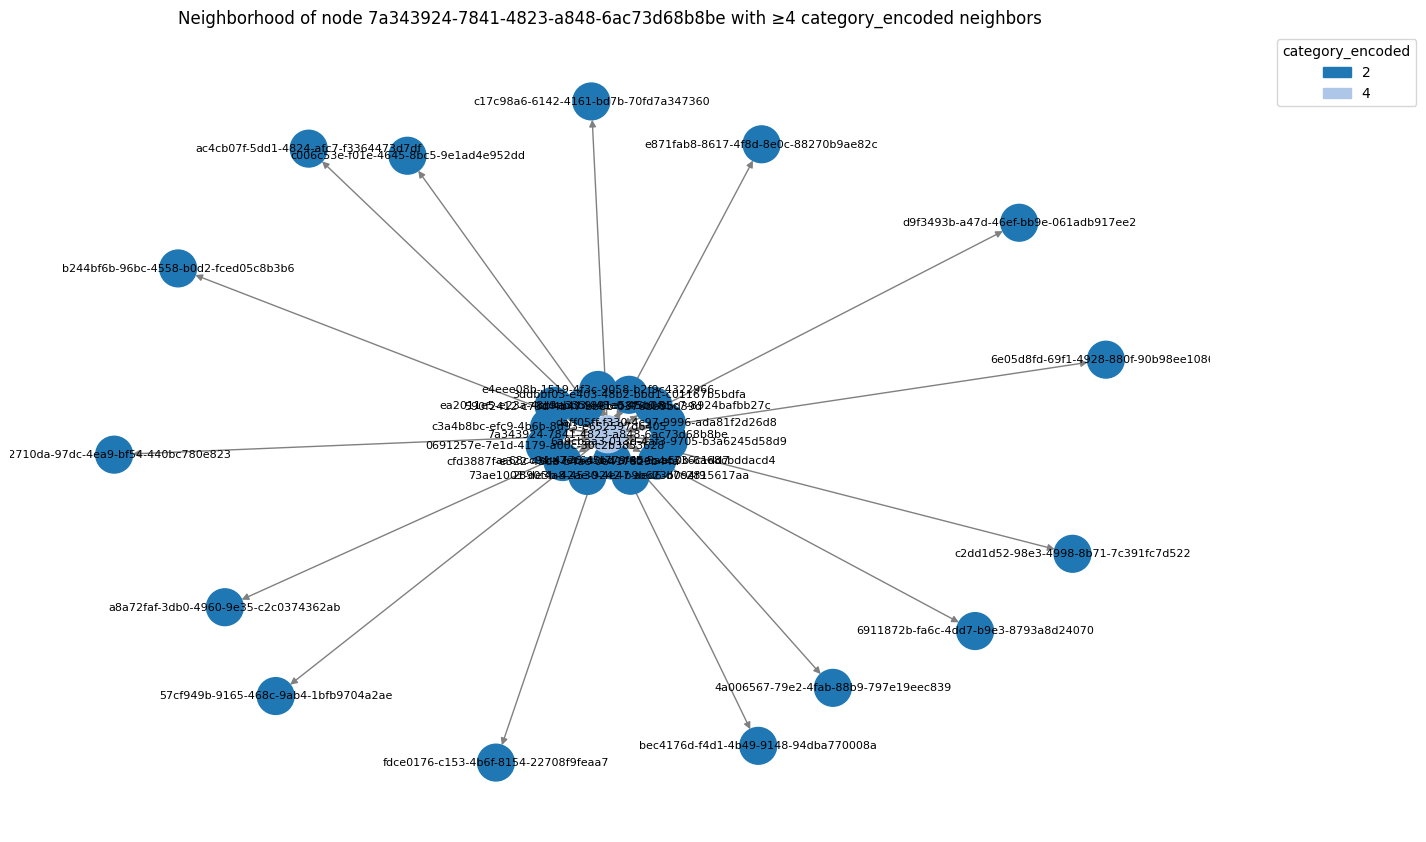

In [10]:
def has_n_distinct_neighbor_categories(G, node, n=4):
    '''
    Check whether a given node in a graph has at least `n` neighbors
    with distinct `category_encoded` values.
    '''
    neighbors = set(nx.all_neighbors(G, node))
    categories = set()
    for nbr in neighbors:
        cat = G.nodes[nbr].get('category_encoded', None)
        if cat is not None:
            categories.add(cat)
        if len(categories) >= n:
            return True
    return False

# Find node connected to ≥ 4 distinct category_encoded neighbors
target_node = None
for node in G.nodes():
    if has_n_distinct_neighbor_categories(G, node, n=4):
        target_node = node
        break

print(f"Found node: {target_node}")

# Visualization of a sub-graph
if target_node:
    neighbors = set(nx.all_neighbors(G, target_node))
    neighbors.add(target_node)
    if len(neighbors) > 30:
        neighbors = set([target_node] + list(neighbors - {target_node})[:29])
    subgraph = G.subgraph(neighbors)

    categories = [G.nodes[n].get('category_encoded', None) for n in subgraph.nodes()]
    unique_categories = list(set(categories))
    cmap = plt.get_cmap('tab20')
    category_to_color = {cat: cmap(i % 20) for i, cat in enumerate(unique_categories)}
    node_colors = [category_to_color.get(cat, (0.5, 0.5, 0.5, 1)) for cat in categories]

    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color=category_to_color[cat], label=str(cat)) for cat in unique_categories]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, seed=42)
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=700, edge_color='gray', font_size=8)
    plt.legend(handles=patches, title="category_encoded", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Neighborhood of node {target_node} with ≥4 category_encoded neighbors")
    plt.tight_layout()
    plt.show()
else:
    print("No node found with 4 or more distinct neighbor categories.")


# BACKEND NETWORK GRAPH DEFINITION

In [11]:
# Backend Network Graph Defintion, creation of nodes and edges
valid_node_ids = set(backend_asset['id'])
filtered_edges = edges2[
    edges2["source_asset_id"].isin(valid_node_ids) &
    edges2["target_asset_id"].isin(valid_node_ids)
]
G = nx.DiGraph()

for _, row in backend_asset.iterrows():
    G.add_node(
        row['id'],
        ipaddress=row['ipaddress'],
        mac_address=row['mac_address'],
        computed_value=row['computed_value'],
        vlan_ids=row['vlan_ids'],
        processing_state=row['processing_state'],
        device_age_days=row['device_age_days'],
        vendor=row['vendor'],
        key=row['key'],
        value=row['value'],
        child_count=row['child_count'],
        has_parent=row['has_parent'],
        category_encoded=row['category_encoded']
    )
for _, row in filtered_edges.iterrows():
    source = row['source_asset_id']
    target = row['target_asset_id']
    if source in G and target in G:
        G.add_edge(
            source,
            target,
            protocol=row.get("protocol"),
            source_port=row.get("source_port"),
            target_port=row.get("target_port"),
            count=row.get("count"),
            bytes=row.get("bytes"),
            key=row.get("key"),
            value=row.get("value")
        )
# Number of nodes and edges
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
features = ['ipaddress', 'mac_address', 'computed_value', 'vlan_ids',
            'processing_state', 'device_age_days', 'vendor', 'key',
            'value', 'child_count', 'has_parent']
# PyTorch geometric data object to test performance on Backend Graph
x_backend = torch.tensor(backend_asset[features].values, dtype=torch.float)
y_backend = torch.tensor(backend_asset['category_encoded'].values, dtype=torch.long)
node_id_to_idx = {node_id: i for i, node_id in enumerate(backend_asset['id'])}
edge_rows = filtered_edges[
    filtered_edges["source_asset_id"].isin(node_id_to_idx) &
    filtered_edges["target_asset_id"].isin(node_id_to_idx)
]
source_indices = edge_rows['source_asset_id'].map(node_id_to_idx).values
target_indices = edge_rows['target_asset_id'].map(node_id_to_idx).values
edge_index_backend = torch.tensor([source_indices, target_indices], dtype=torch.long)
num_nodes = x_backend.size(0)
inference_mask = torch.ones(num_nodes, dtype=torch.bool)
new_data = Data(x=x_backend, edge_index=edge_index_backend, y=y_backend, test_mask=inference_mask)

Graph has 68562 nodes and 467338 edges


/tmp/ipython-input-11-799534961.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index_backend = torch.tensor([source_indices, target_indices], dtype=torch.long)


# Following PyTorch data object creation is used across all models
Note: each model run will result in different results due to randomness in initialization.

In [12]:
# Map node IDs to indices for graph construction
node_id_to_idx = {nid: i for i, nid in enumerate(swiss_asset['id'])}
valid_node_ids = set(node_id_to_idx.keys())
# Filter only edges between nodes that exist in the node dataset
filtered_edges = full_edges[
    full_edges["source_asset_id"].isin(valid_node_ids) &
    full_edges["target_asset_id"].isin(valid_node_ids)
]
# Convert source and target IDs to index values for graph representation
source_indices = filtered_edges['source_asset_id'].map(node_id_to_idx).values
target_indices = filtered_edges['target_asset_id'].map(node_id_to_idx).values
# add edge attributes
edge_index = torch.tensor([source_indices, target_indices], dtype=torch.long)
edge_attr_cols = ['bytes', 'count', 'protocol']
edge_attr_df = filtered_edges[edge_attr_cols].fillna(0).copy()
if 'protocol' in edge_attr_df.columns:
    edge_attr_df['protocol'] = edge_attr_df['protocol'].astype(str)
    edge_attr_df['protocol'] = LabelEncoder().fit_transform(edge_attr_df['protocol'])
edge_attr_tensor = torch.tensor(edge_attr_df.values, dtype=torch.float)

features = ['ipaddress', 'mac_address', 'computed_value', 'vlan_ids',
       'processing_state', 'device_age_days', 'vendor', 'key', 'value',
       'child_count', 'has_parent']
X_numeric = swiss_asset[features].copy()
X_numeric = X_numeric.fillna(0)

# Normalize features using standard scaling (zero mean, unit variance)
scaler = StandardScaler()
X_numeric = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)
# Convert features and labels to PyTorch tensors
x = torch.tensor(X_numeric.values, dtype=torch.float)
y = torch.tensor(swiss_asset['category_encoded'].values, dtype=torch.long)

# Create 80/20 train/test  split using boolean masks
num_nodes = swiss_asset.shape[0]
indices = np.arange(num_nodes)
np.random.shuffle(indices)
train_size = int(0.8 * num_nodes)
train_idx = indices[:train_size]
test_idx = indices[train_size:]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True
# Construct the graph data object for PyTorch Geometric
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)


#Basic Graph Convolutional Network (GCN)

In [13]:
# Basic GCN model
class GCN(torch.nn.Module):
    """
    A simple 2-layer Graph Convolutional Network for node classification.
    """
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=x.shape[1], hidden_dim=16, num_classes=len(y.unique())).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
# Training loop
model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
# Evaluation
model.eval()
out = model(data)
pred = out.argmax(dim=1)
train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
# Detailed classification report on test set
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()
print(classification_report(y_true, y_pred))

Epoch 0, Loss: 1.6789
Epoch 20, Loss: 0.7326
Epoch 40, Loss: 0.2222
Epoch 60, Loss: 0.1294
Epoch 80, Loss: 0.0925
Epoch 100, Loss: 0.0904
Epoch 120, Loss: 0.1012
Epoch 140, Loss: 0.1025
Epoch 160, Loss: 0.0979
Epoch 180, Loss: 0.0750
Epoch 200, Loss: 0.0631
Train Accuracy: 0.9900
Test Accuracy: 0.9889
              precision    recall  f1-score   support

           0       0.75      0.94      0.84       375
           1       0.00      0.00      0.00        47
           2       1.00      1.00      1.00     13648
           3       0.00      0.00      0.00         6
           4       1.00      0.02      0.03        66

    accuracy                           0.99     14142
   macro avg       0.55      0.39      0.37     14142
weighted avg       0.99      0.99      0.99     14142



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Basic GCN performance on Backend Network
new_data = new_data.to(device)
model.eval()
with torch.no_grad():
    logits = model(new_data)
    predictions = logits.argmax(dim=1)
predicted_labels = predictions.cpu().numpy()
if hasattr(new_data, 'y'):
    y_true = new_data.y.cpu().numpy()
    print("\nClassification Report (on backend graph):")
    print(classification_report(y_true, predicted_labels))


Classification Report (on backend graph):
              precision    recall  f1-score   support

           0       1.00      0.03      0.05       270
           1       0.00      0.00      0.00        33
           2       0.99      1.00      1.00     68015
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00       192

    accuracy                           0.99     68562
   macro avg       0.40      0.21      0.21     68562
weighted avg       0.99      0.99      0.99     68562



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# GCN with computed balanced class weights incorporated into the loss function

Epoch 0, Loss: 2.3444
Epoch 20, Loss: 1.1676
Epoch 40, Loss: 0.8573
Epoch 60, Loss: 0.7426
Epoch 80, Loss: 0.6288
Epoch 100, Loss: 0.5729
Epoch 120, Loss: 0.5864
Epoch 140, Loss: 0.5518
Epoch 160, Loss: 0.5342
Epoch 180, Loss: 0.5407
Epoch 200, Loss: 0.5371
Train Accuracy: 0.9869
Test Accuracy: 0.9870
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       375
           1       0.83      0.85      0.84        47
           2       1.00      0.99      0.99     13648
           3       0.06      1.00      0.12         6
           4       0.50      0.82      0.62        66

    accuracy                           0.99     14142
   macro avg       0.67      0.91      0.70     14142
weighted avg       0.99      0.99      0.99     14142



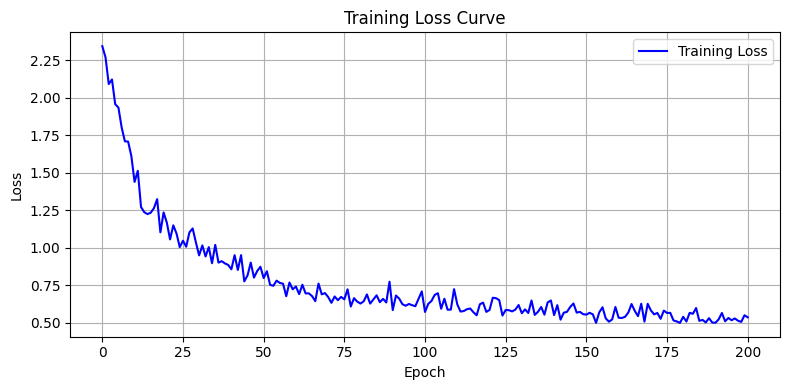

In [15]:
# GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=x.shape[1], hidden_dim=16, num_classes=len(y.unique())).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Computing class weights and incorporating it into loss function
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.numpy())
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)
losses = []
# Training loop
model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    losses.append(loss.item())
# Evaluation
model.eval()
out = model(data)
pred = out.argmax(dim=1)

train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report on test set
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()
print(classification_report(y_true, y_pred))
# Training loss curve
plt.figure(figsize=(8, 4))
plt.plot(range(201), losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# Basic GCN with class weight computed - performance on Backend Network
new_data = new_data.to(device)
model.eval()
with torch.no_grad():
    logits = model(new_data)
    predictions = logits.argmax(dim=1)
predicted_labels = predictions.cpu().numpy()
if hasattr(new_data, 'y'):
    y_true = new_data.y.cpu().numpy()
    print("\nClassification Report (on backend graph):")
    print(classification_report(y_true, predicted_labels))


Classification Report (on backend graph):
              precision    recall  f1-score   support

           0       1.00      0.03      0.05       270
           1       0.00      0.00      0.00        33
           2       0.99      1.00      1.00     68015
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00       192

    accuracy                           0.99     68562
   macro avg       0.40      0.21      0.21     68562
weighted avg       0.99      0.99      0.99     68562



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# GraphSAGE model trained with class weighting

Epoch 0, Loss: 2.0034
Epoch 20, Loss: 0.4804
Epoch 40, Loss: 0.2724
Epoch 60, Loss: 0.1889
Epoch 80, Loss: 0.1591
Epoch 100, Loss: 0.1281
Epoch 120, Loss: 0.1114
Epoch 140, Loss: 0.1001
Epoch 160, Loss: 0.0958
Epoch 180, Loss: 0.0838
Epoch 200, Loss: 0.0884
Train Accuracy: 0.9964
Test Accuracy: 0.9959
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       375
           1       0.87      0.98      0.92        47
           2       1.00      1.00      1.00     13648
           3       0.30      1.00      0.46         6
           4       0.84      0.97      0.90        66

    accuracy                           1.00     14142
   macro avg       0.79      0.98      0.85     14142
weighted avg       1.00      1.00      1.00     14142



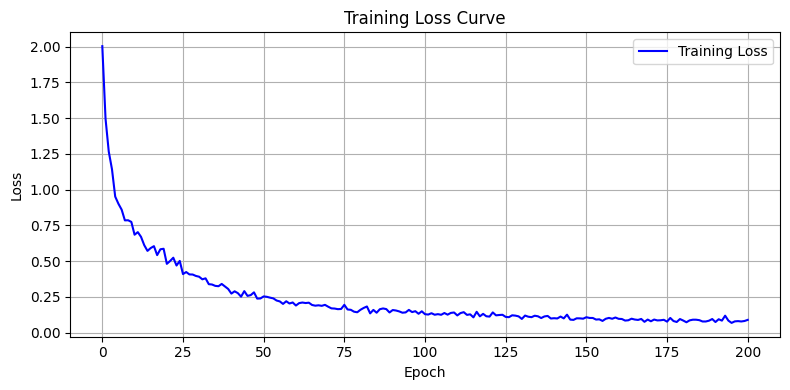

In [17]:
# GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GraphSAGE, self).__init__()
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.sage3 = SAGEConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = self.sage2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.sage3(x, edge_index)
        return x

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(x.shape[1], hidden_dim=32, num_classes=len(y.unique())).to(device)
data = data.to(device)
# Computing class weights and incorporating it into loss function
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y.numpy())
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses = []
# Training Loop
model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    losses.append(loss.item())
# Evaluation
model.eval()
out = model(data)
pred = out.argmax(dim=1)
train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report
print(classification_report(data.y[data.test_mask].cpu().numpy(), pred[data.test_mask].cpu().numpy()))
# Training loss curve
plt.figure(figsize=(8, 4))
plt.plot(range(201), losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

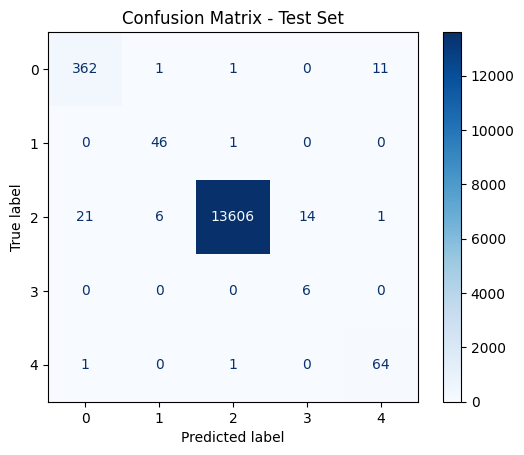

In [18]:
# GraphSAGE confusion matrix
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()

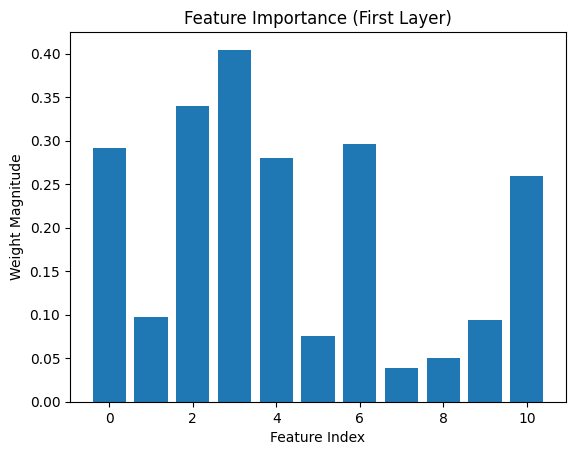

In [19]:
# Feature importance in first layer
with torch.no_grad():
    feature_importance = model.sage1.lin_l.weight.cpu().numpy()
plt.bar(range(feature_importance.shape[1]), np.abs(feature_importance[0]))
plt.xlabel("Feature Index")
plt.ylabel("Weight Magnitude")
plt.title("Feature Importance (First Layer)")
plt.show()

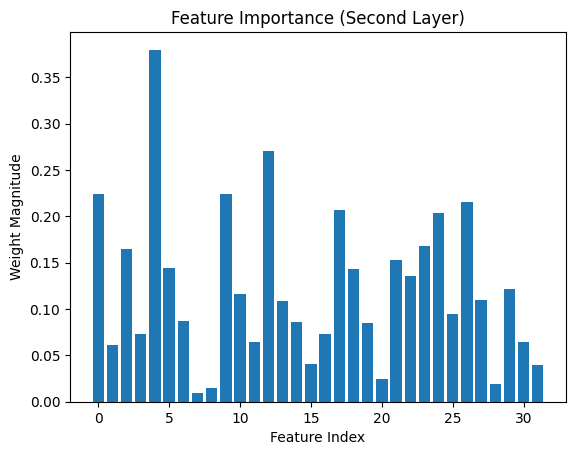

In [20]:
# Feature importance second layer (non-informative)
with torch.no_grad():
    feature_importance = model.sage2.lin_l.weight.cpu().numpy()
plt.bar(range(feature_importance.shape[1]), np.abs(feature_importance[0]))
plt.xlabel("Feature Index")
plt.ylabel("Weight Magnitude")
plt.title("Feature Importance (Second Layer)")
plt.show()

In [21]:
# GraphSAGE performance on Backend network graph
new_data = new_data.to(device)
model.eval()
with torch.no_grad():
    logits = model(new_data)
    predictions = logits.argmax(dim=1)
predicted_labels = predictions.cpu().numpy()
if hasattr(new_data, 'y'):
    y_true = new_data.y.cpu().numpy()
    print("\nClassification Report (on backend graph):")
    print(classification_report(y_true, predicted_labels))


Classification Report (on backend graph):
              precision    recall  f1-score   support

           0       0.00      0.08      0.00       270
           1       0.00      0.94      0.01        33
           2       1.00      0.58      0.73     68015
           3       0.02      0.38      0.03        52
           4       0.00      0.00      0.00       192

    accuracy                           0.57     68562
   macro avg       0.20      0.40      0.15     68562
weighted avg       0.99      0.57      0.72     68562



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Graph Attention Network (GAT)

Epoch 0, Loss: 10.0031
Epoch 20, Loss: 1.8142
Epoch 40, Loss: 1.4721
Epoch 60, Loss: 1.3988
Epoch 80, Loss: 1.9376
Epoch 100, Loss: 1.2759
Epoch 120, Loss: 1.2653
Epoch 140, Loss: 1.2184
Epoch 160, Loss: 1.1964
Epoch 180, Loss: 1.2143
Epoch 200, Loss: 1.2338

Train Accuracy: 0.4497
Test Accuracy: 0.4499

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.07      0.67      0.12       375
           1       0.08      0.45      0.14        47
           2       1.00      0.44      0.61     13648
           3       0.00      1.00      0.00         6
           4       0.08      0.86      0.15        66

    accuracy                           0.45     14142
   macro avg       0.25      0.68      0.20     14142
weighted avg       0.97      0.45      0.60     14142



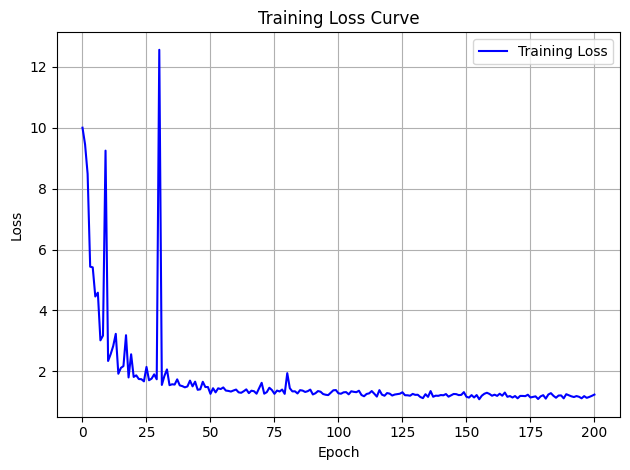

In [22]:
# GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.6):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, attn1 = self.gat1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, attn2 = self.gat2(x, edge_index, return_attention_weights=True)
        return x, attn1, attn2

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=data.num_node_features, hidden_channels=32, out_channels=len(torch.unique(data.y)), heads=4).to(device)
data = data.to(device)
# Computing class weights and incorporating it into loss function
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y.numpy())
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses = []
# Training Loop
model.train()
for epoch in range(201):
    optimizer.zero_grad()
    #out = model(data)
    out, attn1, attn2 = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    losses.append(loss.item())


# Evaluation
model.eval()
out,attn1, attn2 = model(data)
pred = out.argmax(dim=1)
train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
# Classification report on test set
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()
print("\nClassification Report (Test):")
print(classification_report(y_true, y_pred))
# Training Loss Curve
plt.plot(range(201), losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

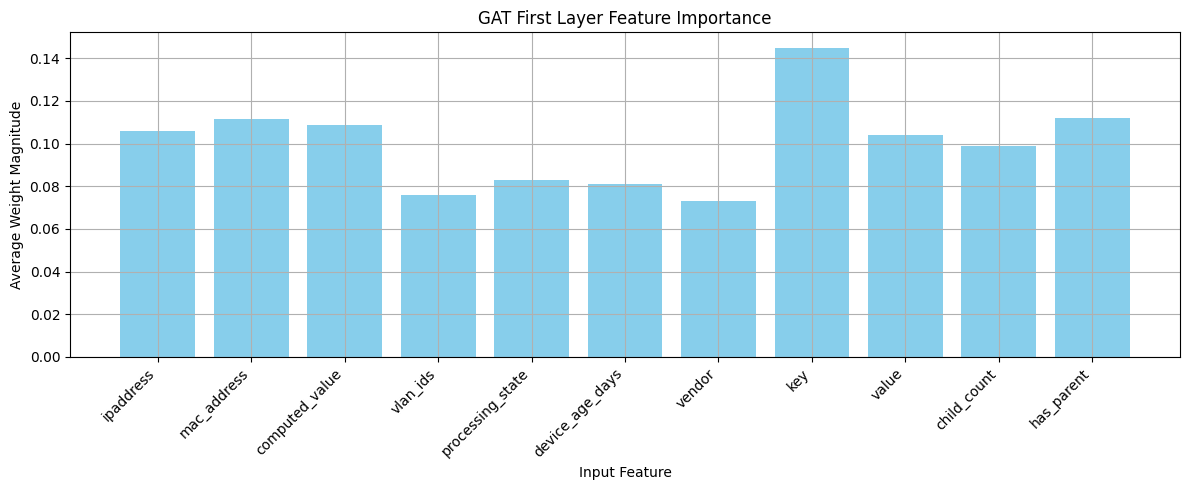

In [23]:
with torch.no_grad():
    feature_importance = model.gat1.lin.weight.cpu().numpy()

# Calculate average absolute importance across all attention heads
avg_importance = np.mean(np.abs(feature_importance), axis=0)

# Feature importance first layer
plt.figure(figsize=(12, 5))
plt.bar(range(len(avg_importance)), avg_importance, color='skyblue')
plt.xticks(range(len(avg_importance)), X_numeric.columns, rotation=45, ha='right')
plt.xlabel("Input Feature")
plt.ylabel("Average Weight Magnitude")
plt.title("GAT First Layer Feature Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# GAT model performance on Backend Network
new_data = new_data.to(device)
model.eval()
with torch.no_grad():
    logits,_,_ = model(new_data)
    predictions = logits.argmax(dim=1)
predicted_labels = predictions.cpu().numpy()
if hasattr(new_data, 'y'):
    y_true = new_data.y.cpu().numpy()
    print("\nClassification Report (on backend graph):")
    print(classification_report(y_true, predicted_labels))


Classification Report (on backend graph):
              precision    recall  f1-score   support

           0       0.00      0.11      0.00       270
           1       0.00      0.00      0.00        33
           2       0.99      0.55      0.71     68015
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00       192

    accuracy                           0.55     68562
   macro avg       0.20      0.13      0.14     68562
weighted avg       0.98      0.55      0.70     68562



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
